# **Problem Statement 1**: ***Trade Logic and Risk Control Basics***


### **Answer 1**

A leverage of less than 1 describes a situation where not all of our existing capital is invested into the market, therefore the equity is partially in terms of cash whilst not utilising any debt to finance our strategy.


Yes, this idea does make sense from a financial point of view as "underutilization" of capital can improve risk-adjusted performance of our investment and also provide a degree lf protection to market drawdowns. I	n the context of our backtestimg engine, the leverage parameter serves as an important tuning instrument for aggressive as well as conservative strategies. A riskier strategy may be assigned a lower "lev" parameter and a safer one will similarly be given a higher tuning parameter.


---



### **Answer 2**

A static stop loss is a fixed price level that a trader sets when buying a stock. This price level bears no relation with the current market price and is simply a predetermined dead-end as far as our trade is concerned. By comparison, a trailing stop loss is a dynamic stop loss that re-adjusts according to a certain relation given by the trader, be it in terms of a raw figure (x rupees below the current trading price) or be it in terms of a certain percentage of this price.

**Behaviour in a Trending Market:** Here, a static stoploss remains as a fixed price band completely isolated from the trading price. This could potentially result in situations where the stoploss ends up being far below the market price in an uptrending market which renders the trader vulnerable to a sharp downtrend. On the other hand, a trailing stop loss "moves" with the traded price in the first place and ensures that there's a viable mark near our trading price to book our accumulated profits even during a sharp downtrend.

**Behaviour in a Volatile Market:** In a volatile market, the static stoploss provides a concrete safety net for prices showing wild variation. This turns out to be a somewhat safer alternative to say a trailing stoploss which can prove to be too tightly associated to the market price, hence resulting in a premature exit during the sharp swings characteristic of a volatile market.


---






### **Answer 3**

In general, outside of certain cases of risk-reward calculation and short term/volatile market trading, the trailing take profit is a key concept that can be of great benefit to any trader especially in a trending market. By following the market price all the way up on an up-trend, the "take-profit" mechanism serves as a way of adapting to evolving market dynamics and protecting accumulated gains.

In fact, as we defined in a prior answer, this mechanism is almost perfectly aligned with the idea of a **trailing stop loss** which is a risk management method that establishes a fixed relation to the market price either in terms of distance or percentage.


---



### **Answer 4**

Scenarios in which a trade remains open even after reaching the stop loss point are associated with the concept of slippage. This is when a trade remains open or gets filled at a less favourable position than the designated stoploss.

There are a few cases that we can take up that exhibit this slippage:

1. *Gapping in markets caused by a significant deviation between the opening price of the trading day wrt the closing price of the preceding day, caused by major political, economic and social factors*

2. *Volatile markets, moving so quickly that they manage to bypass the conversion of stoploss order to a market order, hence filling at a lower price*

3. *Low liquidity arising in cases where there are simply too few participants in the market. There would exist no buyers at our desired price range.*


---



# **Problem Statement 2: *Probabilistic Pattern Validator***

### **1. Pattern Identification**

*Some preparation before the main code*

In [ ]:
!pip install yfinance plotly mplfinance --q

import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import matplotlib.pyplot as plt
import statistics

In [ ]:
def download_stock_data(ticker, start_date, end_date, interval):
  stock_data = yf.download(ticker, start=start_date, end=end_date, interval = interval)
  if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data = stock_data.xs(ticker, axis = 1, level = 1)
    stock_data.columns.name = None
    stock_data.reset_index(inplace=True)
    if stock_data.columns[0] in ['Date', 'Datetime']:
        stock_data.rename(columns={stock_data.columns[0]: 'timestamp'}, inplace=True)
    stock_data.loc[:,'timestamp'] = pd.to_datetime(stock_data['timestamp'])

    return stock_data

chosen_stock = "RELIANCE.NS"
start_date = "2017-01-01"
end_date = "2022-01-01"
interval = "1wk"

stock_data = download_stock_data(chosen_stock, start_date, end_date, interval)
stock_data.dropna().head()

[*********************100%***********************]  1 of 1 completed


,timestamp,Close,High,Low,Open,Volume
0,2017-01-02,239.557877,244.471836,237.184480,241.574715,40504578
1,2017-01-09,243.000992,244.583261,238.677611,240.014732,39661275
2,2017-01-16,228.604584,243.792146,228.181157,242.900736,91184205
3,2017-01-23,228.448593,230.142287,225.707481,227.713178,68846240
4,2017-01-30,230.353973,234.844491,228.381704,228.415132,64434214


In [ ]:
chart = go.Figure(data=[go.Candlestick(x=stock_data.index,
                                            open = stock_data['Open'],
                                            high = stock_data['High'],
                                            low = stock_data['Low'],
                                            close = stock_data['Close'])])

chart.update_layout(title=f'Candlestick Chart - {chosen_stock}',xaxis_title='Date',xaxis_rangeslider_visible=True,yaxis_title='Price')
chart.show()

In [ ]:
tolerance_doji = 0.1
tolerance_hammer = 2

def find_doji_patterns(df):
  doji_indices = []
  for i in range(len(df)):
    open = df['Open'].iloc[i]
    close = df['Close'].iloc[i]
    high = df['High'].iloc[i]
    low = df['Low'].iloc[i]

    body = abs(close - open)
    range_trade = high - low
    if range_trade > 0 and body / range_trade < tolerance_doji:
      doji_indices.append(df.index[i])
  return doji_indices

def find_hammer_patterns(df):
  hammer_indices= []
  for i in range(len(df)):
    open = df['Open'].iloc[i]
    close = df['Close'].iloc[i]
    high = df['High'].iloc[i]
    low = df['Low'].iloc[i]

    body = abs(close - open)
    lower_shadow = min(open, close) - low
    upper_shadow = high - max(open, close)

    if lower_shadow > tolerance_hammer * body and upper_shadow < body:
      hammer_indices.append(df.index[i])
  return hammer_indices

def find_engulfing_patterns(df):
  engulfing_indices = []
  for i in range(len(df)):
    prev_Open = df['Open'].iloc[i-1]
    prev_Close = df['Close'].iloc[i-1]
    curr_Open = df['Open'].iloc[i]
    curr_Close = df['Close'].iloc[i]

    curr_body = abs(curr_Close - curr_Open)
    prev_body = abs(prev_Close - prev_Open)

    if curr_Close > curr_Open and prev_Close < prev_Open:
      if curr_Open <= prev_Close and curr_Close >= prev_Open:
        engulfing_indices.append(df.index[i])
    if curr_Close < curr_Open and prev_Close > prev_Open:
      if curr_Close <= prev_Open and curr_Open >= prev_Close:
        engulfing_indices.append(df.index[i])
  return engulfing_indices

doji_patterns = find_doji_patterns(stock_data)
hammer_patterns = find_hammer_patterns(stock_data)
engulfing_patterns = find_engulfing_patterns(stock_data)

print(f"Identified Doji patterns on dates: {doji_patterns}")
print(f"Identified Hammer patterns on dates: {hammer_patterns}")
print(f"Identified Engulfing patterns on dates: {engulfing_patterns}")


Identified Doji patterns on dates: [51, 52, 57, 76, 81, 101, 108, 135, 137, 143, 151, 163, 184, 195, 196, 200, 207, 210, 216, 224, 227, 241, 249, 260]
Identified Hammer patterns on dates: [11, 20, 73, 112, 125, 156, 167, 171, 179, 207, 234]
Identified Engulfing patterns on dates: [12, 19, 25, 31, 37, 39, 56, 71, 90, 102, 104, 106, 109, 132, 149, 157, 159, 168, 180, 182, 191, 201, 222, 228, 235, 238, 245, 246, 254, 258]




---


### **2. Win-Rate Calculation**

In [ ]:
def find_win_rate(df, pattern, n):
  wins = 0
  total_pats = 0

  for i in pattern:
    t_day = df.index.get_loc(i)
    look_ahead = t_day + n

    if look_ahead < len(df):
      total_pats += 1
      net = df['Close'].iloc[look_ahead] - df['Close'].iloc[t_day]
      if net > 0:
        wins +=1
  if total_pats == 0:
    win_rate = 0
  else:
    win_rate = (wins/total_pats) * 100
  return win_rate

print(f"Doji pattern win rate with 3-day window = {find_win_rate(stock_data,doji_patterns,3):0.2f}%")
print(f"Hammer pattern win rate with 3-day window = {find_win_rate(stock_data,hammer_patterns,3):0.2f}%")
print(f"Engulfing pattern win rate with 3-day window = {find_win_rate(stock_data,engulfing_patterns,3):0.2f}%")

print(f"Doji pattern win rate with 5-day window = {find_win_rate(stock_data,doji_patterns,5):0.2f}%")
print(f"Hammer pattern win rate with 5-day window = {find_win_rate(stock_data,hammer_patterns,5):0.2f}%")
print(f"Engulfing pattern win rate with 5-day window = {find_win_rate(stock_data,engulfing_patterns,5):0.2f}%")

Doji pattern win rate with 3-day window = 52.17%
Hammer pattern win rate with 3-day window = 63.64%
Engulfing pattern win rate with 3-day window = 68.97%
Doji pattern win rate with 5-day window = 56.52%
Hammer pattern win rate with 5-day window = 63.64%
Engulfing pattern win rate with 5-day window = 79.31%




---

### **3. Baseline Win-Rate**


In [ ]:
def win_rate_random(df,M,n):
  num_candles = len(df) - n
  num_patterns = 0
  if num_candles <= 0 :
    return 0
  else:
    random_wins = 0
    for i in range(M):
      random_day = np.random.randint(0, num_candles)
      if random_day + n < num_candles:
         random_net = df['Close'].iloc[random_day + n] - df['Close'].iloc[random_day]
         num_patterns += 1
      if random_net > 0:
         random_wins += 1
  if num_patterns == 0:
    return 0
  else:
    win_rate_random = (random_wins/num_patterns) * 100
    return win_rate_random

print(f"Empirical win rate of patterns created by random entries = {win_rate_random(stock_data, 1000, 3):0.2f} %")

Empirical win rate of patterns created by random entries = 57.72 %




---

### **4. Visualization**

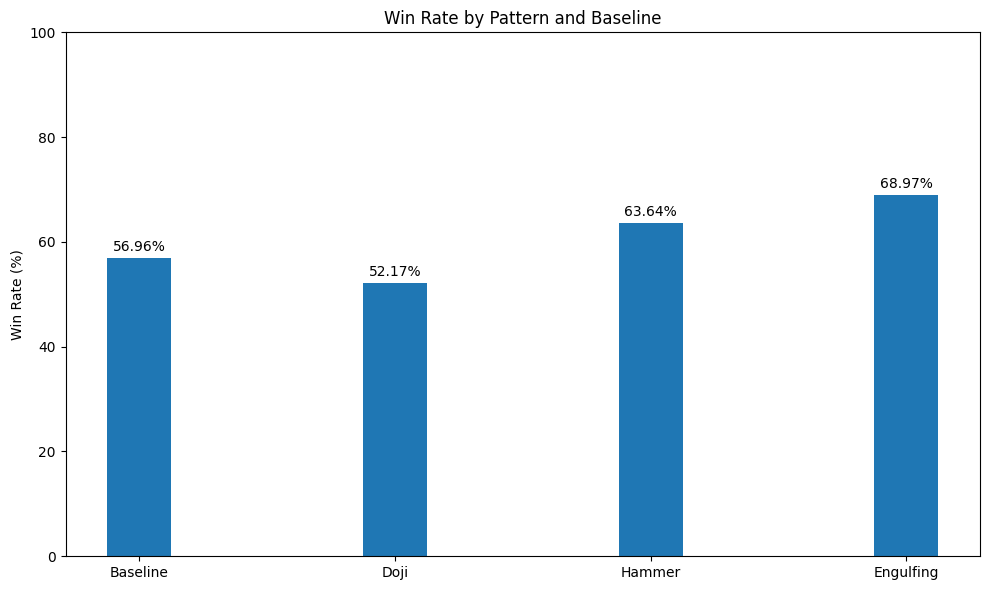

In [ ]:
labels = ['Baseline','Doji','Hammer','Engulfing']
win_rates = [win_rate_random(stock_data,1000,3),find_win_rate(stock_data,doji_patterns,3),find_win_rate(stock_data,hammer_patterns,3),find_win_rate(stock_data,engulfing_patterns,3)]
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(labels))
width = 0.25
rect = ax.bar(x, win_rates, width)

ax.set_ylabel('Win Rate (%)')
ax.set_title('Win Rate by Pattern and Baseline')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,100)

def autolabels(rect):
  for i in rect:
    height = i.get_height()
    ax.annotate(f'{height:.2f}%',
                xy = (i.get_x() + i.get_width()/2, height),
                xytext = (0,3), textcoords = 'offset points',
                ha = 'center', va = 'bottom')

autolabels(rect)

plt.tight_layout()
plt.show()

**Answer 1**

The *Doji candlestick pattern* represents a state of indecision in the market. The small body with large upper and lower shadows indicate that neither the bulls nor the bears have managed to take control over the market. As such, these patterns by themselves give a very neutral possibility of positive returns as seen by the ~50% win rate.

The *Hammer candlestick pattern* appears during a downtrend and is identified by a large lower shadow and a small upper one. This indicates failure of the bears to take control of the market and is the first stage of bullish resurgence in trading prices.

The *engulfing candlestick pattern* has shown to be the likeliest winner amongst the three patterns we have described here. This happens because of the huge reversal in trends induced by one of the candles showing significantly greater opposite momentum.


---



**Answer 2**

As n evolves, we can expect the Baseline win-rate to consistently hover just above 50% owing to the overall upward growth of RELIANCE shares. As for the patterns, we can make the following inferences:


*   Doji will plateau if not decline after that 5-candle mark since it indicates indecision and market uncertainty, bearing no short or medium term reversals or uptrends to boost the trading price.
*   Hammer is a stable growth signal in the short to mid-term which may taper off after some 5-10 candles as the bears recover in the market, since a hammer is not highhly time sensitive. Being a solitary candlestick, there are good odds of recovery.
*   Engulfing Candlestick pattern on the other hand, has the potential to remain high up to 10 sessions or more since they capture trend beginnings that can aggressively take over the market as time progresses.






---

**Answer 3**

I would expect the hammer candlestick to be the most consistent since it captures a short burst of reversal and is a time in-sensitive signal that does not noticeably disrupt the make-up of the market in the medium term. Whenever we see a Hammer form, more often than not, it is accompanied by buying pressure that creates a stable climb. However, this uptrend is not as steep as it would be for engulfing candlesticks for example, and we would notice a similar trend for n = 3,5.. and so on.



---

# **Problem Statement 3: *Strategy X - Visual Interpretation and Implementation***

### **1. Chart Interpretation**

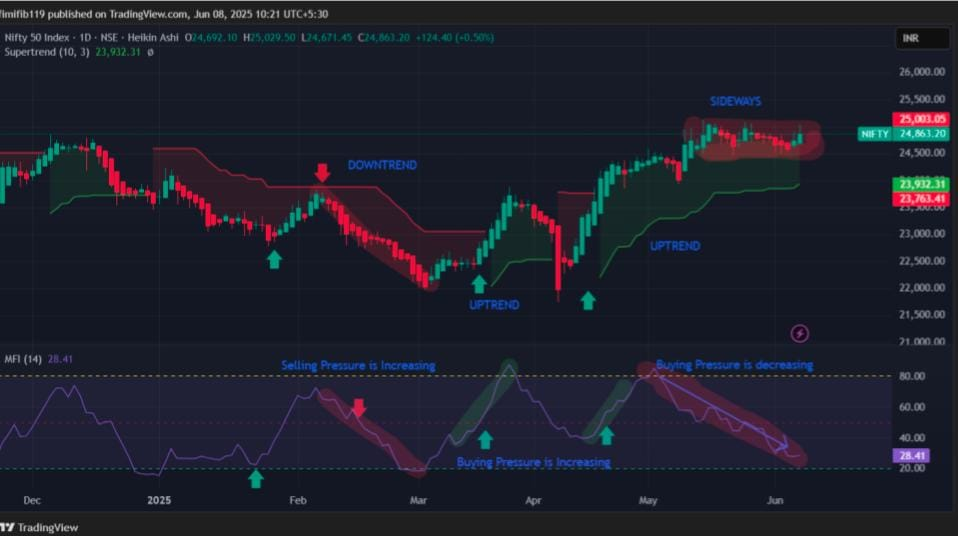

This chart utilises the following technical indicators:


*   *Heiken Ashi Candles*
*   *Supertrend Indicator*
*   *MFI Indicator*

The green upward arrows suggest entry points for a long position while the red ones signal entry for a short position. In the MFI window, the first two marked regions indicate areas of sustained selling and buying pressure respectively as the MFI makes a sharp reversal of trend from an extreme position. On the other hand, the last region is a case of decreasing buying pressure as there is no bearish dominance to bring about a sharp reversal in the MFI, resulting in an "easing" out of bullish pressure.

Finally, in the Heiken Ashi-supertrend chart, we see annotations ("UPTREND", "DOWNTREND", "SIDEWAYS") corresponding to the actual trends suggested by this indicator.




---

# **2. Entry and Exit Rules**

**Conditions for Long Entry**


1.   Supertrend turns bullish (turns green)
2.   MFI rises sharply from an oversold or almost oversold region.
3.   Price crosses over supertrend


**Conditions for Short Entry**


1.   Supertrend turns bearish (turns red)
2.   MFI falls sharply from an overbought or almost overbought region.
3.   Price crosses below supertrend

**Conditions for Long Exit**


1.   Supertrend reverses direction
2.   MFI starts to gradually decrease over time showing falling buying pressure.

**Conditions for Long Entry**

1.   Supertrend reverses direction
2.   MFI starts to gradually increase over time showing falling selling pressure.

*Alternative Rule Variant*

One possible addition to introduce further nuance into deciding the best possible entry position could be to use ATR *(Average True Rate)* to allow entries only when the market has the necessary momentum to carry a successful trade. We can also introduce MFI thresholds to quantify what constitutes a sharp MFI fall/rise in a given interval of time, for e.g. say MFI reaching 30 from an oversold position in a certain interval.



---

# **3. Strategy Implementation and Backtest**

In [ ]:
def download_flat_yf(ticker, start, end, interval):

  data = yf.download(ticker, start=start, end=end, interval=interval,
 progress=False)
  if isinstance(data.columns, pd.MultiIndex):
       data = data.xs(ticker, axis=1, level=1)
  data.columns.name = None
  data.reset_index(inplace=True)
  data.columns = [col.lower() for col in data.columns]
  if data.columns[0] in ['date', 'datetime']:
       data.rename(columns={data.columns[0]: 'timestamp'}, inplace=True)
       data['timestamp'] = pd.to_datetime(data['timestamp'])
  return data

stock_symbol = 'CAMS.NS'
data = download_flat_yf(stock_symbol, start='2024-01-01', end= '2025-05-04', interval='1d')
data.head()

,timestamp,close,high,low,open,volume
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066
1,2024-01-02,2619.587891,2644.413041,2600.797445,2605.163867,143141
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428
3,2024-01-04,2657.512695,2693.229349,2620.863682,2624.788600,268532
4,2024-01-05,2696.565674,2716.043175,2661.290522,2674.095615,354882


In [ ]:
def calculate_typical_price(df):
    return (df['High'] + df['Low'] + df['Close']) / 3

def calculate_mfi(df, window=14):
    tp = calculate_typical_price(df)
    volume = df['Volume']

    money_flow = tp * volume

    positive_mf = np.where(tp > tp.shift(1), money_flow, 0)
    negative_mf = np.where(tp < tp.shift(1), money_flow, 0)

    positive_mf_sum = pd.Series(positive_mf).rolling(window=window).sum()
    negative_mf_sum = pd.Series(negative_mf).rolling(window=window).sum()

    mfi = 100 - (100 / (1 + positive_mf_sum / negative_mf_sum))
    return mfi

def calculate_supertrend(df, period=10, multiplier=3):
    df['tr'] = np.maximum(np.maximum(df['High'] - df['Low'], abs(df['High'] - df['Close'].shift(1))), abs(df['Low'] - df['Close'].shift(1)))
    df['atr'] = df['tr'].rolling(period).mean()

    df['basic_upper'] = (df['High'] + df['Low']) / 2 + multiplier * df['atr']
    df['basic_lower'] = (df['High'] + df['Low']) / 2 - multiplier * df['atr']

    df['final_upper'] = df['basic_upper']
    df['final_lower'] = df['basic_lower']

    for i in range(1, len(df)):
      if df['Close'].iloc[i] > df['final_upper'].iloc[i-1]:
        df.loc[df.index[i], 'final_upper'] = df['basic_upper'].iloc[i]
      else:
        df.loc[df.index[i], 'final_upper'] = min(df['basic_upper'].iloc[i], df['final_upper'].iloc[i-1])

      if df['Close'].iloc[i] < df['final_lower'].iloc[i-1]:
        df.loc[df.index[i], 'final_lower'] = df['basic_lower'].iloc[i]
      else:
        df.loc[df.index[i], 'final_lower'] = max(df['basic_lower'].iloc[i], df['final_lower'].iloc[i-1])

    df['supertrend'] = np.nan
    for i in range(period, len(df)):
        if df['Close'].iloc[i] > df['final_upper'].iloc[i-1]:
          df.loc[df.index[i], 'supertrend'] = df['final_lower'].iloc[i]
        elif df['Close'].iloc[i] < df['final_lower'].iloc[i-1]:
          df.loc[df.index[i], 'supertrend'] = df['final_upper'].iloc[i]
        else:
          df.loc[df.index[i], 'supertrend'] = df['supertrend'].iloc[i-1]

    return df['supertrend']

mfi_window=14
supertrend_period=10
supertrend_multiplier=3
mfi_oversold=30
mfi_overbought=70
mfi_delta_threshold=5

stock_data['mfi'] = calculate_mfi(stock_data.copy(), window=mfi_window)
stock_data['supertrend'] = calculate_supertrend(stock_data.copy(), period=supertrend_period, multiplier=supertrend_multiplier)

In [ ]:
stock_data['Signals'] = 0

for i in range(1, len(stock_data)):

    long_entry_condition_1 = (stock_data['supertrend'].iloc[i] < stock_data['Close'].iloc[i]) and (stock_data['supertrend'].iloc[i-1] >= stock_data['Close'].iloc[i-1])
    long_entry_condition_2 = (stock_data['mfi'].iloc[i] > stock_data['mfi'].iloc[i-1] + mfi_delta_threshold) and (stock_data['mfi'].iloc[i-1] <= mfi_oversold)

    if long_entry_condition_1 and long_entry_condition_2:
        stock_data.loc[stock_data.index[i], 'Signals'] = 1

    short_entry_condition_1 = (stock_data['supertrend'].iloc[i] > stock_data['Close'].iloc[i]) and (stock_data['supertrend'].iloc[i-1] <= stock_data['Close'].iloc[i-1])
    short_entry_condition_2 = (stock_data['mfi'].iloc[i] < stock_data['mfi'].iloc[i-1] - mfi_delta_threshold) and (stock_data['mfi'].iloc[i-1] >= mfi_overbought)

    if short_entry_condition_1 and short_entry_condition_2:
        stock_data.loc[stock_data.index[i], 'Signals'] = -1

In [ ]:
def perform_backtest(dataframe, lev=1, initial_capital=100000 , lot_size=1, tsl=100):
    dataframe = dataframe.copy()
    capital_list = [initial_capital]
    trade = 0  # 0 = no Open trade, 1 = long trade Open, -1 = short trade Open
    position_size = 0
    trade_profit = []
    entry, exit = [], []
    entry_index, exit_index = [], []
    nol, nos = 0, 0  # Number of long and short trades
    long_profit, short_profit = [], []
    trade_type = []
    position_size_list = []

    # Calculate benchmark returns over entire backtest period
    benchmark_returns = (dataframe.loc[dataframe.index[-1], 'Close'] / dataframe.loc[dataframe.index[0], 'Close'] - 1) * 100

    # Calculate backtest period in years and months
    backtest_period = dataframe.loc[dataframe.index[-1], 'timestamp'] - dataframe.loc[dataframe.index[0], 'timestamp']
    total_days = backtest_period.days
    years = total_days // 365
    remaining_days = total_days % 365
    months = remaining_days // 30

    max_price = 0  # For tracking trailing stop price

    for i in range(len(dataframe)):
        date = dataframe.loc[i, 'timestamp']
        current_price = dataframe.loc[i, 'Close']
        high_price = dataframe.loc[i, 'High']

        # Stop if capital is exhausted
        if capital_list[-1] <= 0:
            print(f'Complete capital lost on {date}')
            break

        # Open Long trade if no trade is Open and signal is long (1)
        if trade == 0 and dataframe.loc[i, 'Signals'] == 1:
            position_size = (capital_list[-1] * lev) // (current_price * lot_size)
            cost = position_size * current_price * lot_size
            if cost > 0:
                position_size_list.append(position_size * lot_size)
                trade = 1
                entry.append(date)
                entry_index.append(i)
                max_price = current_price  # Initialize max price for trailing stop
            else:
                position_size = 0

        # Open Short trade if no trade is Open and signal is short (-1)
        elif trade == 0 and dataframe.loc[i, 'Signals'] == -1:
            position_size = (capital_list[-1] * lev) // (current_price * lot_size)
            cost = position_size * current_price * lot_size
            if cost > 0:
                position_size_list.append(position_size * lot_size)
                trade = -1
                entry.append(date)
                entry_index.append(i)
                max_price = current_price  # Initialize min price for trailing stop (will update below)
            else:
                position_size = 0

        # Manage Open trade and trailing stop
        elif trade != 0:
            if trade == 1:
                # Update max price seen during long trade for trailing stop loss
                max_price = max(max_price, high_price)
                # Check if current Close triggers trailing stop loss exit
                if dataframe.loc[i, 'Close'] <= (1 - tsl / 100) * max_price:
                    # Set signal to Close long and Open short (or just Close)
                    dataframe.loc[i, 'Signals'] = -1  # force exit long
                    max_price = 0

            elif trade == -1:
                # For short, track minimum price for trailing stop loss
                max_price = min(max_price, high_price)
                # Check if current Close triggers trailing stop loss exit
                if dataframe.loc[i, 'Close'] >= (1 + tsl / 100) * max_price:
                    dataframe.loc[i, 'Signals'] = 1  # force exit short
                    max_price = 0


            if dataframe.loc[i, 'Signals'] * trade == -1:
                exit.append(date)
                exit_index.append(i)
                if trade == 1:
                    nol += 1
                    profit = lot_size * current_price * position_size - cost
                else:
                    nos += 1
                    profit = cost - lot_size * current_price * position_size

                capital_list.append(capital_list[-1] + profit)
                trade_profit.append(profit)

                if trade == 1:
                    long_profit.append(profit)
                else:
                    short_profit.append(profit)

                trade_type.append('Long' if trade == 1 else 'Short')
                trade = 0
                position_size = 0
                cost = 0


    if trade != 0:
        exit.append(dataframe.iloc[-1]['timestamp'])
        exit_index.append(len(dataframe) - 1)
        if trade == 1:
            nol += 1
            profit = dataframe.iloc[-1]['Close'] * position_size * lot_size - cost
            trade_type.append('Long')
        else:
            nos += 1
            profit = cost - dataframe.iloc[-1]['Close'] * position_size * lot_size
            trade_type.append('Short')
        capital_list.append(capital_list[-1] + profit)
        trade_profit.append(profit)


    returns = np.diff(capital_list) / capital_list[:-1]
    downside_returns = returns[returns < 0]

    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 0 and np.std(returns) > 0 else float('nan')
    sortino_ratio = np.mean(returns) / np.std(downside_returns) * np.sqrt(252) if len(downside_returns) > 0 and np.std(downside_returns) > 0 else float('nan')

    number_of_trades = len(trade_profit)

    capital_series = pd.Series(capital_list)
    running_max = capital_series.cummax()
    drawdowns = (capital_series - running_max) / running_max
    drawdowns = drawdowns[drawdowns <= 0]

    print(f'BACKTEST RESULTS:')
    if number_of_trades == 0:
        print('No trades taken')
        return

    print(f"Backtest Period: {years} years and {months} months")
    print(f'Benchmark Returns: {benchmark_returns * lev:.2f} %')
    print(f'Initial Capital: {capital_list[0]}')
    print(f'Final Capital: {capital_list[-1]:.2f}')
    print(f'Profit percentage: {(capital_list[-1] - capital_list[0]) / capital_list[0] * 100:.2f} %')
    print(f'Leverage applied: {lev}')
    print(f'Maximum Portfolio balance: {max(capital_list):.2f}')
    print(f'Minimum Portfolio balance: {min(capital_list):.2f}')
    print(f'Number of trades: {number_of_trades}')

    win = sum(1 for profit in trade_profit if profit > 0)
    print(f'Winning Trades: {win}')
    print(f'Losing Trades: {number_of_trades - win}')
    print(f'Win Rate: {win / number_of_trades * 100:.2f} %')

    try:
        avg_profit = statistics.mean([x for x in trade_profit if x > 0])
    except:
        avg_profit = 0
    try:
        avg_loss = statistics.mean([x for x in trade_profit if x <= 0])
    except:
        avg_loss = 0

    print(f'Average Profit: {avg_profit:.2f}')
    print(f'Average Loss: {avg_loss:.2f}')
    print(f'No of Long Trades: {nol}')
    print(f'No of Short Trades: {nos}')
    print(f'Average drawdown: {np.mean(drawdowns) * 100:.2f} %')
    print(f'Maximum drawdown: {np.min(drawdowns) * 100:.2f} %')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print(f'Sortino Ratio: {sortino_ratio:.2f}')


    if entry and exit:
        holding_times = [(exit[i] - entry[i]) for i in range(len(entry))]
        max_holding_time = max(holding_times)
        days = max_holding_time.days
        hours, remainder = divmod(max_holding_time.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f'Maximum Holding Time: {days} days, {hours:02}:{minutes:02}:{seconds:02}')

        avg_holding_time = sum(holding_times, pd.Timedelta(0)) / len(holding_times)
        days_avg = avg_holding_time.days
        hours_avg, remainder_avg = divmod(avg_holding_time.seconds, 3600)
        minutes_avg, seconds_avg = divmod(remainder_avg, 60)
        print(f'Average Holding Time: {days_avg} days, {hours_avg:02}:{minutes_avg:02}:{seconds_avg:02}')

    fig = sp.make_subplots(
        rows=2, cols=1, shared_xaxes=True,
        subplot_titles=('Equity Curve', 'Price Action with Entry and Exit Points'),
        vertical_spacing=0.1
    )

    fig.add_trace(go.Scatter(
        y=capital_list,
        mode='lines',
        name='Capital',
        line=dict(color='green')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=dataframe['timestamp'],
        y=dataframe['Close'],
        mode='lines',
        name='Close Price',
        line=dict(color='blue')
    ), row=2, col=1)

    # Entry markers
    fig.add_trace(go.Scatter(
        x=[dataframe['timestamp'].iloc[i] for i in entry_index],
        y=[dataframe['Close'].iloc[i] for i in entry_index],
        mode='markers',
        marker=dict(symbol='triangle-up', color='green', size=10),
        name='Entry'
    ), row=2, col=1)


    fig.add_trace(go.Scatter(
        x=[dataframe['timestamp'].iloc[i] for i in exit_index],
        y=[dataframe['Close'].iloc[i] for i in exit_index],
        mode='markers',
        marker=dict(symbol='triangle-down', color='red', size=10),
        name='Exit'
    ), row=2, col=1)

    fig.update_layout(
        height=800,
        title_text='Backtest Visualizations',
        showlegend=True,
        template='plotly_white'
    )

    fig.update_xaxes(title_text='Time', row=2, col=1)
    fig.update_yaxes(title_text='Capital', row=1, col=1)
    fig.update_yaxes(title_text='Price', row=2, col=1)

    fig.show()


    trade_log = pd.DataFrame({
        'Entry Candle': entry,
        'Exit Candle': exit,
        'PnL': trade_profit,
        'Number of units': position_size_list,
        'Trade type': trade_type
    })

    return trade_log

In [ ]:
def remove_redundant_signals(data):
    prev_signal = 0
    prev_i = 0
    trade = 0

    for i in range(len(data)):
        if prev_signal == 0 and data.loc[i, 'Signals'] != 0:
            prev_signal = data.loc[i, 'Signals']
            prev_i = i

        elif prev_signal != 0:
            if data.loc[i, 'Signals'] * prev_signal > 0:
                data.loc[i, 'Signals'] = 0
            elif data.loc[i, 'Signals'] * prev_signal < 0:
                trade = (
                    data.loc[prev_i, 'Close'] - data.loc[i, 'Close']
                    if prev_signal < 0
                    else data.loc[i, 'Close'] - data.loc[prev_i, 'Close']
                )
                prev_signal = data.loc[i, 'Signals']
                prev_i = i

    return data

In [ ]:
dataframe = stock_data[['timestamp', 'Open','High','Low','Close','Volume','Signals']]
stock_data = remove_redundant_signals(dataframe)
perform_backtest(dataframe)

BACKTEST RESULTS:
Backtest Period: 4 years and 12 months
Benchmark Returns: 354.73 %
Initial Capital: 100000
Final Capital: 43051.21
Profit percentage: -56.95 %
Leverage applied: 1
Maximum Portfolio balance: 100000.00
Minimum Portfolio balance: 43051.21
Number of trades: 1
Winning Trades: 0
Losing Trades: 1
Win Rate: 0.00 %
Average Profit: 0.00
Average Loss: -56948.79
No of Long Trades: 0
No of Short Trades: 1
Average drawdown: -28.47 %
Maximum drawdown: -56.95 %
Sharpe Ratio: nan
Sortino Ratio: nan
Maximum Holding Time: 175 days, 00:00:00
Average Holding Time: 175 days, 00:00:00


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2020-01-27,2020-07-20,-56948.794373,159.0,Short




---

# **4. Incorporating a Complementary Indicator**

We can introduce the ATR indicator to our existing strategy in order to introduce a new analytical angle, namely that of accounting for marketing volatility and momentum. This can help us avoid entering trades in low volatility periods and adapt our position sizing and stop losses. It complements MFI and supertrend ideally:



1.   *Supertrend: even though this indicator is structurally ATR-based, ATR isn't actually utilised for gauging entry or exit points. Hence, we are expanding upon its utility.*
2.   *While MFI overlaps with the overbought-and-oversold nature of Bollinger Bands, it does not account for volatility which we can successfully integrate with ATR*



### **STRATEGY Y: *STRATEGY X + ATR FILTER***

**Additional Logic:** Enter trades only when ATR is above a certain threshold, say 65 percentile within the last 10-intervals' worth of ATR values

In [ ]:
def calculate_atr(df, period=10):
    tr = np.maximum(np.maximum(df['High'] - df['Low'], abs(df['High'] - df['Close'].shift(1))), abs(df['Low'] - df['Close'].shift(1)))
    atr = pd.Series(tr).rolling(window=period).mean()
    return atr

def calculate_typical_price(df):
    return (df['High'] + df['Low'] + df['Close']) / 3

def calculate_mfi(df, window=14):
    tp = calculate_typical_price(df)
    volume = df['Volume']

    money_flow = tp * volume

    positive_mf = np.where(tp > tp.shift(1), money_flow, 0)
    negative_mf = np.where(tp < tp.shift(1), money_flow, 0)

    positive_mf_sum = pd.Series(positive_mf).rolling(window=window).sum()
    negative_mf_sum = pd.Series(negative_mf).rolling(window=window).sum()
    mfi = 100 - (100 / (1 + positive_mf_sum / negative_mf_sum.replace(0, np.nan)))
    return mfi

def calculate_supertrend(df, period=10, multiplier=3):
    df['tr'] = np.maximum(np.maximum(df['High'] - df['Low'], abs(df['High'] - df['Close'].shift(1))), abs(df['Low'] - df['Close'].shift(1)))
    df['atr'] = df['tr'].rolling(period).mean()

    df['basic_upper'] = (df['High'] + df['Low']) / 2 + multiplier * df['atr']
    df['basic_lower'] = (df['High'] + df['Low']) / 2 - multiplier * df['atr']

    df['final_upper'] = df['basic_upper']
    df['final_lower'] = df['basic_lower']

    for i in range(1, len(df)):
      if df['Close'].iloc[i] > df['final_upper'].iloc[i-1]:
        df.loc[df.index[i], 'final_upper'] = df['basic_upper'].iloc[i]
      else:
        df.loc[df.index[i], 'final_upper'] = min(df['basic_upper'].iloc[i], df['final_upper'].iloc[i-1])

      if df['Close'].iloc[i] < df['final_lower'].iloc[i-1]:
        df.loc[df.index[i], 'final_lower'] = df['basic_lower'].iloc[i]
      else:
        df.loc[df.index[i], 'final_lower'] = max(df['basic_lower'].iloc[i], df['final_lower'].iloc[i-1])

    df['supertrend'] = np.nan
    for i in range(period, len(df)):
        if df['Close'].iloc[i] > df['final_upper'].iloc[i-1]:
          df.loc[df.index[i], 'supertrend'] = df['final_lower'].iloc[i]
        elif df['Close'].iloc[i] < df['final_lower'].iloc[i-1]:
          df.loc[df.index[i], 'supertrend'] = df['final_upper'].iloc[i]
        else:
          df.loc[df.index[i], 'supertrend'] = df['supertrend'].iloc[i-1]

    return df['supertrend']


mfi_window=14
supertrend_period=10
supertrend_multiplier=3
mfi_oversold=30
mfi_overbought=70
mfi_delta_threshold=5
atr_threshold_window = 10


stock_data['mfi'] = calculate_mfi(stock_data.copy(), window=mfi_window)
stock_data['supertrend'] = calculate_supertrend(stock_data.copy(), period=supertrend_period, multiplier=supertrend_multiplier)
stock_data['atr'] = calculate_atr(stock_data)

stock_data['atr_threshold'] = stock_data['atr'].rolling(window=atr_threshold_window).quantile(0.65)


stock_data['Signals'] = 0

for i in range(1, len(stock_data)):

    if i < atr_threshold_window or pd.isna(stock_data['supertrend'].iloc[i-1]) or pd.isna(stock_data['mfi'].iloc[i-1]):
        continue


    long_entry_condition_1 = (stock_data['supertrend'].iloc[i] < stock_data['Close'].iloc[i]) and (stock_data['supertrend'].iloc[i-1] >= stock_data['Close'].iloc[i-1])
    long_entry_condition_2 = (stock_data['mfi'].iloc[i] > stock_data['mfi'].iloc[i-1] + mfi_delta_threshold) and (stock_data['mfi'].iloc[i-1] <= mfi_oversold)
    atr_condition_long = stock_data['atr'].iloc[i] >= stock_data['atr_threshold'].iloc[i]

    if long_entry_condition_1 and long_entry_condition_2 and atr_condition_long:
        stock_data.loc[stock_data.index[i], 'Signals'] = 1


    short_entry_condition_1 = (stock_data['supertrend'].iloc[i] > stock_data['Close'].iloc[i]) and (stock_data['supertrend'].iloc[i-1] <= stock_data['Close'].iloc[i-1])
    short_entry_condition_2 = (stock_data['mfi'].iloc[i] < stock_data['mfi'].iloc[i-1] - mfi_delta_threshold) and (stock_data['mfi'].iloc[i-1] >= mfi_overbought)
    atr_condition_short = stock_data['atr'].iloc[i] >= stock_data['atr_threshold'].iloc[i]
    if short_entry_condition_1 and short_entry_condition_2 and atr_condition_short:
        stock_data.loc[stock_data.index[i], 'Signals'] = -1


dataframe2 = stock_data[['timestamp', 'Open','High','Low','Close','Volume','Signals', 'supertrend', 'mfi']]

perform_backtest(dataframe2)

BACKTEST RESULTS:
Backtest Period: 4 years and 12 months
Benchmark Returns: 354.73 %
Initial Capital: 100000
Final Capital: 43051.21
Profit percentage: -56.95 %
Leverage applied: 1
Maximum Portfolio balance: 100000.00
Minimum Portfolio balance: 43051.21
Number of trades: 1
Winning Trades: 0
Losing Trades: 1
Win Rate: 0.00 %
Average Profit: 0.00
Average Loss: -56948.79
No of Long Trades: 0
No of Short Trades: 1
Average drawdown: -28.47 %
Maximum drawdown: -56.95 %
Sharpe Ratio: nan
Sortino Ratio: nan
Maximum Holding Time: 175 days, 00:00:00
Average Holding Time: 175 days, 00:00:00


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2020-01-27,2020-07-20,-56948.794373,159.0,Short




---


# **5. Strategy Enhancements**

The following market regimes pose a risk to our strategy:



1.   *Sideways and Range Bound Market:* Supertrend whipsaws while MFI fluctuates aimlessly
2.   *Low-Volume*: MFI is essentially volume adjusted RSI
3.   *Choppy/Noisy Market:* frequent crossovers of supertrend triggering fake entries and exits.

All of this can be improved upon by implementing a 200-day EMA trend filter: in *long situation*, proceed ONLY if price > 200 day EMA and vice-versa for *short situations.*


---

